## IMPORTING LIBRARIES

In [3]:
#installation required for Spark
!pip install sparkmagic
!pip install pyspark
!pip install plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 711.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 27.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## CREATION OF SPARK SESSION

In [4]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
spark_df = spark.read.csv('/content/Churn_Modelling.csv', inferSchema=True, header=True)
spark_df.show(10)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [6]:
print("Shape: ", (spark_df.count(), len(spark_df.columns)))

Shape:  (10000, 14)


The table summarizes data for 10,000 bank customers

In [7]:
spark_df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [8]:
# convert everything in lowercase
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|rownumber|customerid| surname|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [9]:
# Drop specified columns
columns_to_drop = ['rownumber', 'customerid', 'surname']
spark_df = spark_df.select([column for column in spark_df.columns if column not in columns_to_drop])
spark_df.show(5)

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+-----------+---------+------+---+------+---------+-------------+---------+-------------

In [10]:
# check for missing values
from pyspark.sql.functions import when, count, col
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
creditscore,0
geography,0
gender,0
age,0
tenure,0
balance,0
numofproducts,0
hascrcard,0
isactivemember,0
estimatedsalary,0


In [11]:
spark_df.describe().show()

+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|      creditscore|geography|gender|               age|            tenure|          balance|     numofproducts|          hascrcard|     isactivemember|  estimatedsalary|             exited|
+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|         650.5288|     NULL|  NULL|           38.9218|            5.0128|76485.88928799961|            1.5302|             0.7055|             0.5151|100090.2398809998|             0.2037|
| stddev|9

Key statistics include an average credit score of 650.53, an average age of 38.92, and an average balance of 76,485.89. About 70.55% have a credit card, 51.51% are active members, and 20.37% have exited the bank.

## **Exploratory Data Analysis**

In [12]:
spark_df.groupby("exited").count().show()

+------+-----+
|exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



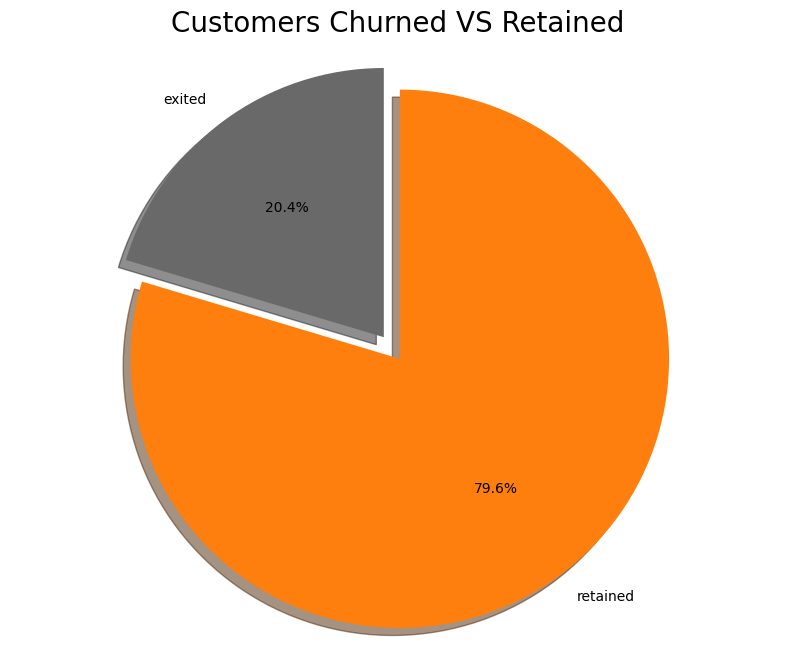

In [13]:
# The proportion of customers who have churned (Exited) versus those who have been retained.

from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Calculate the counts for Exited and Retained
exit_counts = spark_df.groupBy('exited').count().orderBy('exited')

# Extract the counts
sizes = [exit_counts.filter(col('exited') == 1).select('count').first()[0],
         exit_counts.filter(col('exited') == 0).select('count').first()[0]]

# Plotting
labels = ['exited', 'retained']
explode = (0, 0.1)
colors = ['dimgrey', '#FF7F0E']  # Specify colors here

fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)  # Pass colors to the pie function
ax1.axis('equal')
plt.title("Customers Churned VS Retained", size=20)
plt.show()


The pie chart provides a snapshot of customer churn in the dataset, revealing that around 20% of customers have exited. The baseline assumption is a straightforward one: anticipating that each customer has a 20% likelihood of churning.

In [14]:
spark_df.groupby("exited").agg({"tenure": "mean"}).show()

+------+-----------------+
|exited|      avg(tenure)|
+------+-----------------+
|     1|4.932744231713304|
|     0|5.033278914981791|
+------+-----------------+



Customers who exited the bank (exited=1) have an average tenure of about 4.93, whereas those who did not exit (exited=0) exhibit a slightly higher average tenure of approximately 5.03. This implies a subtle difference in the average tenure between customers who have exited and those who have not.

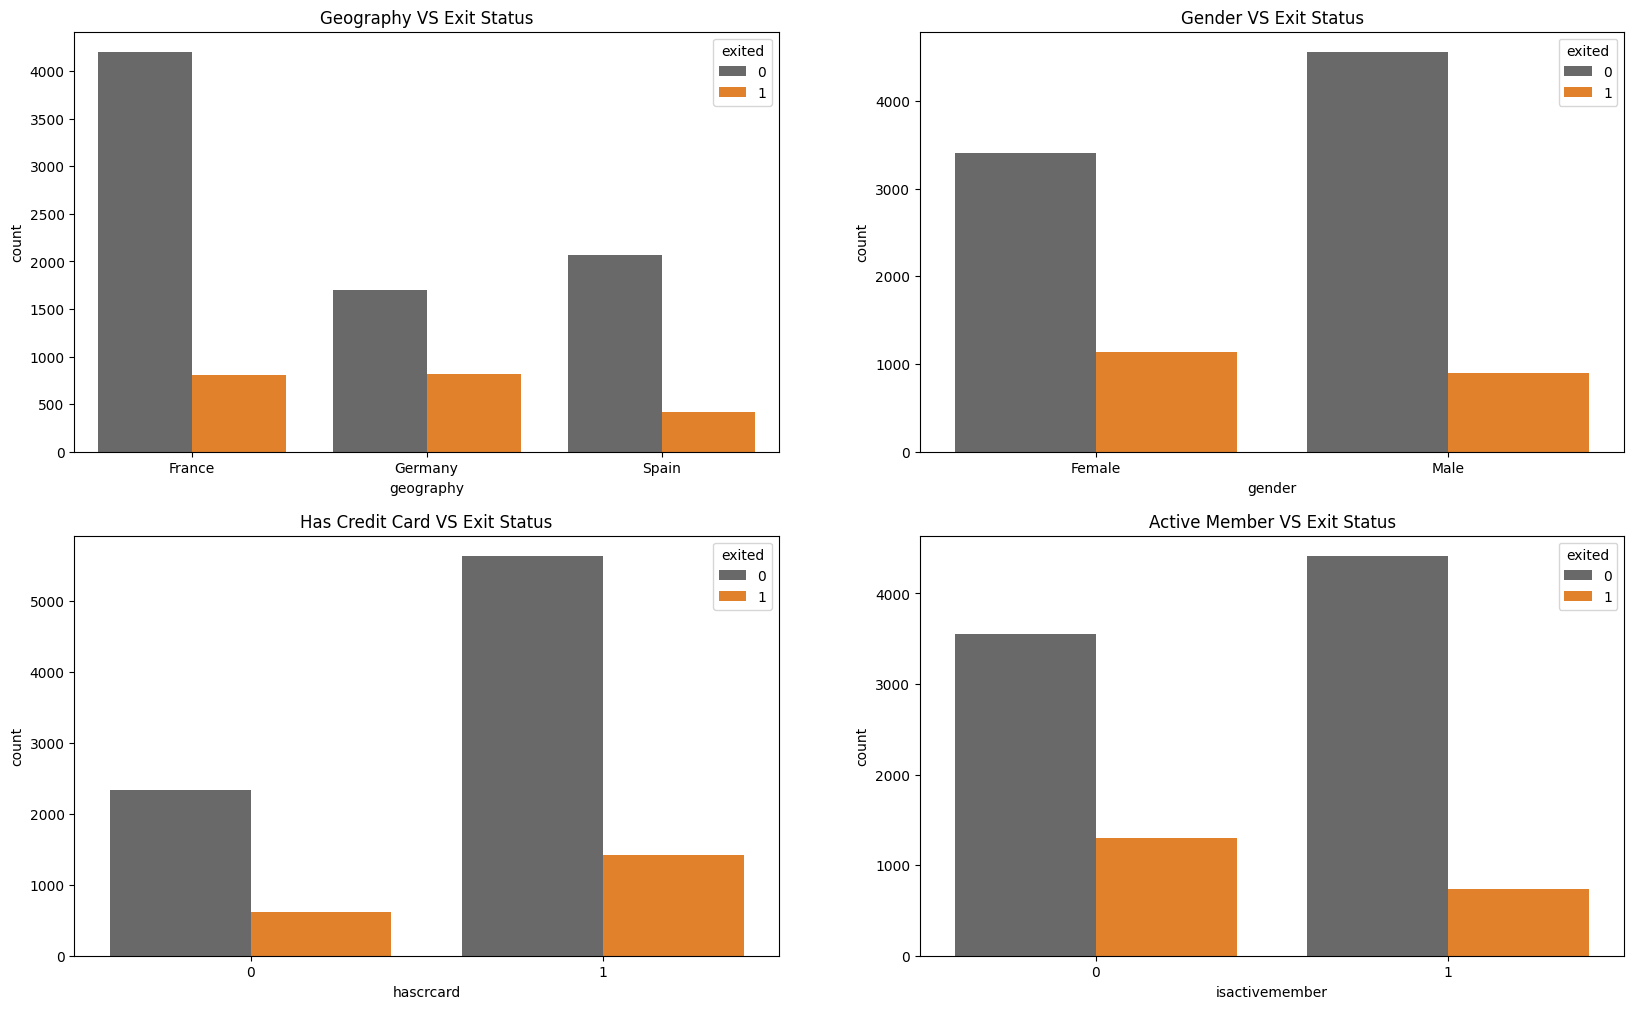

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set color palette
colors = ['dimgrey', '#FF7F0E']
sns.set_palette(sns.color_palette(colors))

# Create subplots
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))

# Plot for 'Geography'
geography_counts = spark_df.groupBy('geography', 'exited').count().orderBy('geography', 'exited')
sns.barplot(x='geography', y='count', hue='exited', data=geography_counts.toPandas(), ax=axarr[0][0])
axarr[0][0].set_title('Geography VS Exit Status')

# Plot for 'Gender'
gender_counts = spark_df.groupBy('gender', 'exited').count().orderBy('gender', 'exited')
sns.barplot(x='gender', y='count', hue='exited', data=gender_counts.toPandas(), ax=axarr[0][1])
axarr[0][1].set_title('Gender VS Exit Status')

# Plot for 'HasCrCard'
has_cr_card_counts = spark_df.groupBy('hascrcard', 'exited').count().orderBy('hascrcard', 'exited')
sns.barplot(x='hascrcard', y='count', hue='exited', data=has_cr_card_counts.toPandas(), ax=axarr[1][0])
axarr[1][0].set_title('Has Credit Card VS Exit Status')

# Plot for 'IsActiveMember'
is_active_member_counts = spark_df.groupBy('isactivemember', 'exited').count().orderBy('isactivemember', 'exited')
sns.barplot(x='isactivemember', y='count', hue='exited', data=is_active_member_counts.toPandas(), ax=axarr[1][1])
axarr[1][1].set_title('Active Member VS Exit Status')

# Show the plots
plt.show()


In [16]:
# Group by 'geography' and 'exited', then count the occurrences
geography_counts = spark_df.groupBy('geography', 'exited').count().orderBy('geography', 'exited')

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
geography_counts_pandas = geography_counts.toPandas()

# Print the counts for each combination
print(geography_counts_pandas)


  geography  exited  count
0    France       0   4204
1    France       1    810
2   Germany       0   1695
3   Germany       1    814
4     Spain       0   2064
5     Spain       1    413


In [17]:
# Group by 'gender' and 'exited', then count the occurrences
gender_counts = spark_df.groupBy('gender', 'exited').count().orderBy('gender', 'exited')

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
gender_counts_pandas = gender_counts.toPandas()

# Print the counts for each combination
print(gender_counts_pandas)

   gender  exited  count
0  Female       0   3404
1  Female       1   1139
2    Male       0   4559
3    Male       1    898


In [18]:
# Group by 'has_cr_card' and 'exited', then count the occurrences
has_cr_card_counts = spark_df.groupBy('hascrcard', 'exited').count().orderBy('hascrcard', 'exited')

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
has_cr_card_counts_pandas = has_cr_card_counts.toPandas()

# Print the counts for each combination
print(has_cr_card_counts_pandas)

   hascrcard  exited  count
0          0       0   2332
1          0       1    613
2          1       0   5631
3          1       1   1424


In [19]:
# Group by 'is_active_member' and 'exited', then count the occurrences
is_active_member_counts = spark_df.groupBy('isactivemember', 'exited').count().orderBy('isactivemember', 'exited')

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
is_active_member_counts_pandas = is_active_member_counts.toPandas()

# Print the counts for each combination
print(is_active_member_counts_pandas)


   isactivemember  exited  count
0               0       0   3547
1               0       1   1302
2               1       0   4416
3               1       1    735


The dataset predominantly comprises data from individuals in France. However, an intriguing observation emerges when examining the proportion of churned customers: it appears inversely related to the overall population of customers. This suggests the possibility of a challenge for the bank, potentially indicating issues such as insufficient allocation of customer service resources in regions with fewer clients.

A gender-based analysis reveals that the proportion of female customers experiencing churn is higher than that of their male counterparts. This gender-specific disparity in churn rates raises questions and warrants further investigation.

An interesting finding emerges when exploring the relationship between credit card ownership and customer churn. Despite the majority of customers having credit cards, the proportion of churned customers is notably higher among those with credit cards. While this may initially seem coincidental, it prompts consideration of potential factors influencing this trend.

Notably, the data highlights that inactive members exhibit a higher churn rate. What raises concern is the overall proportion of inactive members, which is substantial. This suggests a need for the bank to implement programs aimed at converting inactive members into active customers. Such initiatives could potentially have a positive impact on mitigating customer churn.

In summary, these observations shed light on various facets of customer churn, from geographical patterns to gender differentials and the impact of credit card ownership and activity levels.

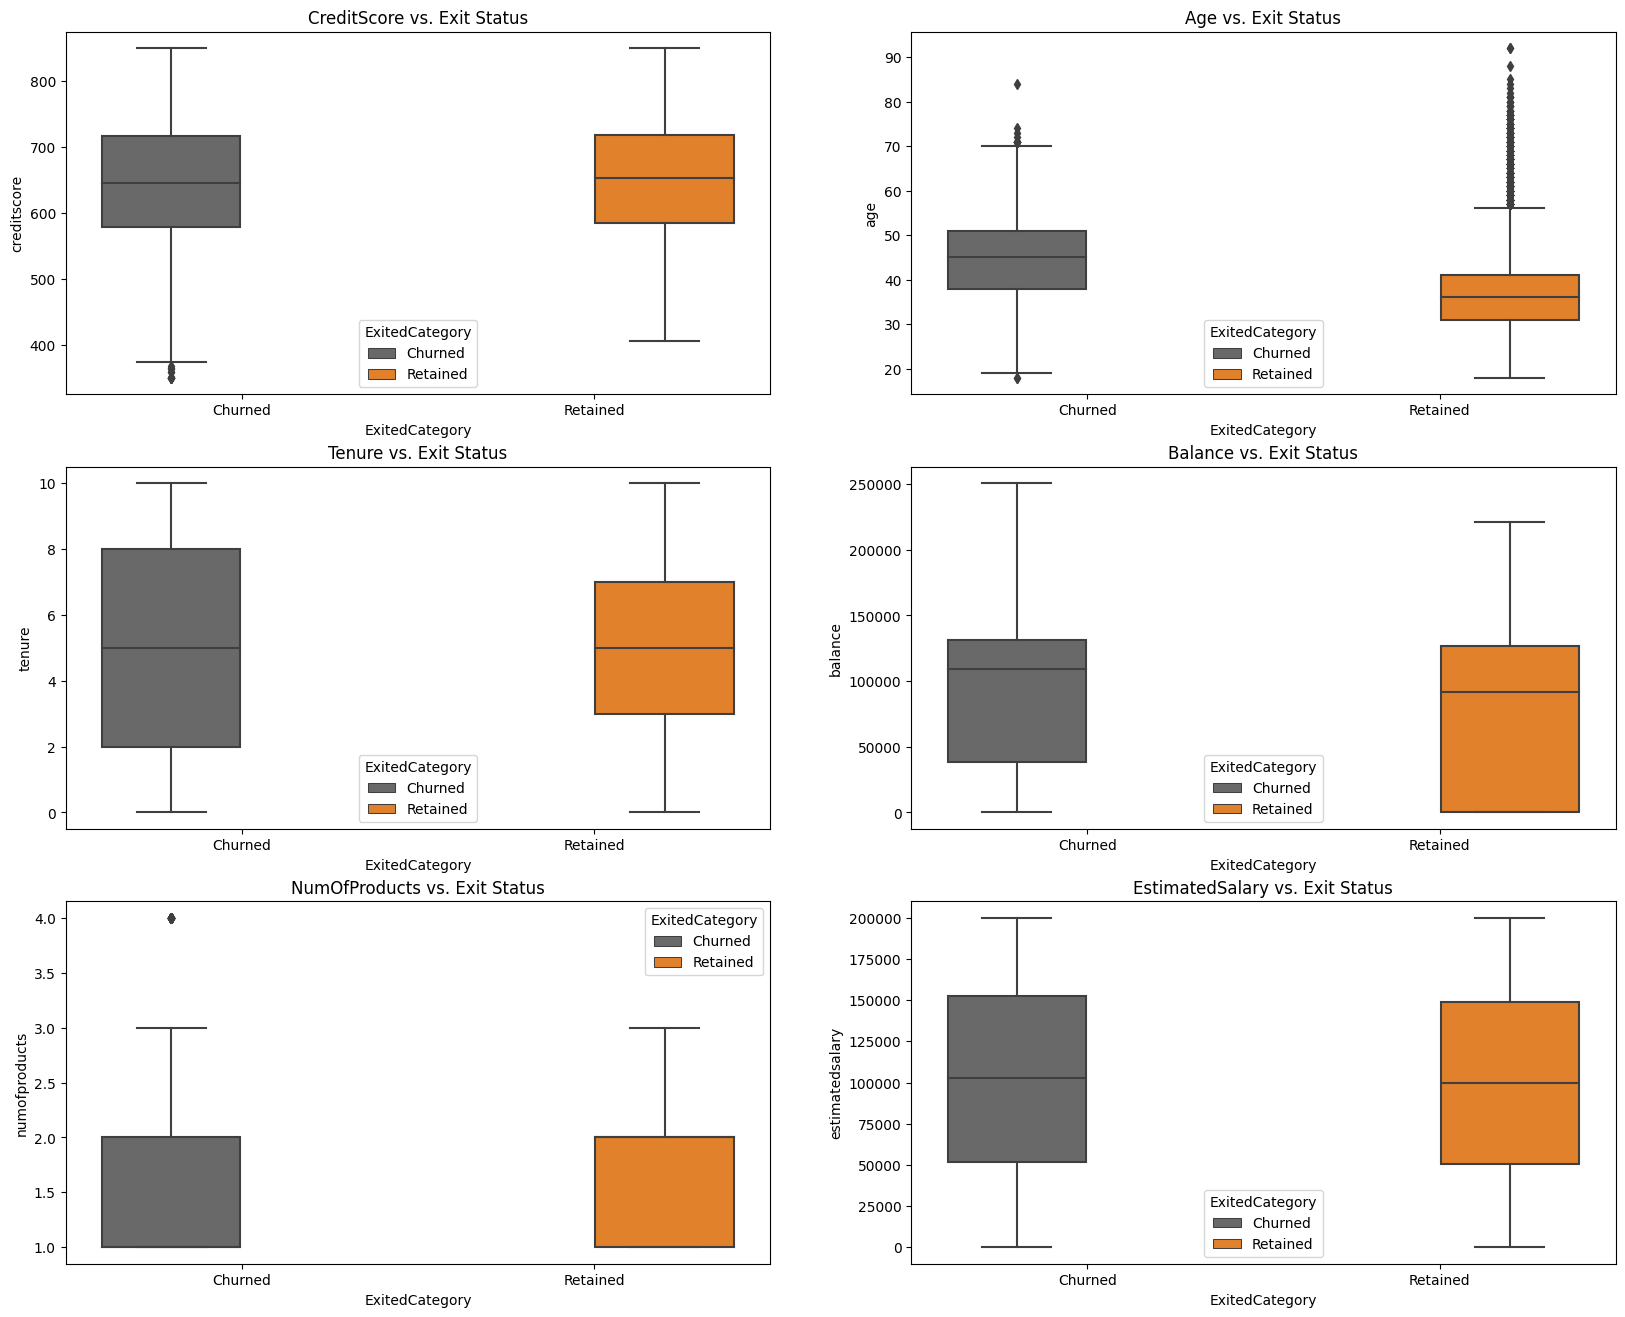

In [20]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# Create a new categorical column for 'Exited' status
spark_df = spark_df.withColumn('ExitedCategory', F.when(col('Exited') == 1, 'Churned').otherwise('Retained'))

# Set color palette
colors = ['dimgrey', '#FF7F0E']
sns.set_palette(sns.color_palette(colors))

# Create subplots
fig, axarr = plt.subplots(3, 2, figsize=(20, 16))

# Function to create boxplots
def create_boxplot(data, x, y, hue, ax):
    sns.boxplot(x=x, y=y, hue=hue, data=data.toPandas(), ax=ax)

# Boxplot for 'CreditScore'
create_boxplot(spark_df, 'ExitedCategory', 'creditscore', 'ExitedCategory', axarr[0][0])
axarr[0][0].set_title('CreditScore vs. Exit Status')

# Boxplot for 'Age'
create_boxplot(spark_df, 'ExitedCategory', 'age', 'ExitedCategory', axarr[0][1])
axarr[0][1].set_title('Age vs. Exit Status')

# Boxplot for 'Tenure'
create_boxplot(spark_df, 'ExitedCategory', 'tenure', 'ExitedCategory', axarr[1][0])
axarr[1][0].set_title('Tenure vs. Exit Status')

# Boxplot for 'Balance'
create_boxplot(spark_df, 'ExitedCategory', 'balance', 'ExitedCategory', axarr[1][1])
axarr[1][1].set_title('Balance vs. Exit Status')

# Boxplot for 'NumOfProducts'
create_boxplot(spark_df, 'ExitedCategory', 'numofproducts', 'ExitedCategory', axarr[2][0])
axarr[2][0].set_title('NumOfProducts vs. Exit Status')

# Boxplot for 'EstimatedSalary'
create_boxplot(spark_df, 'ExitedCategory', 'estimatedsalary', 'ExitedCategory', axarr[2][1])
axarr[2][1].set_title('EstimatedSalary vs. Exit Status')

# Show the plots
plt.show()


The credit score distribution does not exhibit a significant variance between retained and churned customers. However, an interesting trend emerges concerning age: older customers demonstrate a higher likelihood of churning compared to their younger counterparts. This observation suggests a potential divergence in service preferences among different age groups. Consequently, the bank might consider reevaluating its target market or refining its retention strategies tailored to distinct age demographics.

In terms of tenure, customers at the extremes—those who have spent minimal time with the bank and those with a prolonged history—are more prone to churning compared to those with an average tenure. This highlights the importance of addressing the needs of both new and long-standing clients to enhance retention efforts.

A concerning trend emerges regarding customers with substantial bank balances, as they show a higher propensity to churn. This could have implications for the bank's available capital for lending, urging a closer examination of strategies to retain customers with significant financial holdings.

Surprisingly, neither the variety of products used nor the estimated salary demonstrates a substantial impact on the likelihood of churning. This insight suggests that other factors may play a more influential role in customer retention, prompting the need for a comprehensive analysis of additional variables to identify effective retention strategies.

In [21]:
# Display descriptive statistics for 'CreditScore' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('creditscore').alias('min_creditscore'),
    F.max('creditscore').alias('max_creditscore'),
    F.mean('creditscore').alias('mean_creditscore'),
    F.stddev('creditscore').alias('stddev_creditscore')
).show()


+--------------+---------------+---------------+-----------------+------------------+
|ExitedCategory|min_creditscore|max_creditscore| mean_creditscore|stddev_creditscore|
+--------------+---------------+---------------+-----------------+------------------+
|       Churned|            350|            850|645.3514972999509|100.32150264961571|
|      Retained|            405|            850|651.8531960316463| 95.65383704715589|
+--------------+---------------+---------------+-----------------+------------------+



In [22]:
# Display descriptive statistics for 'Age' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('age').alias('min_age'),
    F.max('age').alias('max_age'),
    F.mean('age').alias('mean_age'),
    F.stddev('age').alias('stddev_age')
).show()


+--------------+-------+-------+-----------------+-----------------+
|ExitedCategory|min_age|max_age|         mean_age|       stddev_age|
+--------------+-------+-------+-----------------+-----------------+
|       Churned|     18|     84| 44.8379970544919|9.761561555507182|
|      Retained|     18|     92|37.40838879819164|10.12536291104753|
+--------------+-------+-------+-----------------+-----------------+



In [23]:
# Display descriptive statistics for 'Tenure' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('tenure').alias('min_tenure'),
    F.max('tenure').alias('max_tenure'),
    F.mean('tenure').alias('mean_tenure'),
    F.stddev('tenure').alias('stddev_tenure')
).show()

+--------------+----------+----------+-----------------+------------------+
|ExitedCategory|min_tenure|max_tenure|      mean_tenure|     stddev_tenure|
+--------------+----------+----------+-----------------+------------------+
|       Churned|         0|        10|4.932744231713304|2.9361062684311996|
|      Retained|         0|        10|5.033278914981791|2.8806577432683733|
+--------------+----------+----------+-----------------+------------------+



In [24]:
# Display descriptive statistics for 'Balance' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('balance').alias('min_balance'),
    F.max('balance').alias('max_balance'),
    F.mean('balance').alias('mean_balance'),
    F.stddev('balance').alias('stddev_balance')
).show()

+--------------+-----------+-----------+-----------------+------------------+
|ExitedCategory|min_balance|max_balance|     mean_balance|    stddev_balance|
+--------------+-----------+-----------+-----------------+------------------+
|       Churned|        0.0|  250898.09|91108.53933726063| 58360.79481585523|
|      Retained|        0.0|   221532.8|72745.29677885193|62848.040700619924|
+--------------+-----------+-----------+-----------------+------------------+



In [25]:
# Display descriptive statistics for 'NumOfProducts' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('numofproducts').alias('min_numofproducts'),
    F.max('numofproducts').alias('max_numofproducts'),
    F.mean('numofproducts').alias('mean_numofproducts'),
    F.stddev('numofproducts').alias('stddev_numofproducts')
).show()

+--------------+-----------------+-----------------+------------------+--------------------+
|ExitedCategory|min_numofproducts|max_numofproducts|mean_numofproducts|stddev_numofproducts|
+--------------+-----------------+-----------------+------------------+--------------------+
|       Churned|                1|                4|1.4752086401570939|  0.8015205454864539|
|      Retained|                1|                3|1.5442672359663443|  0.5095355243311022|
+--------------+-----------------+-----------------+------------------+--------------------+



In [26]:
# Display descriptive statistics for 'EstimatedSalary' by 'ExitedCategory'
spark_df.groupBy('ExitedCategory').agg(
    F.min('estimatedsalary').alias('min_estimatedsalary'),
    F.max('estimatedsalary').alias('max_estimatedsalary'),
    F.mean('estimatedsalary').alias('mean_estimatedsalary'),
    F.stddev('estimatedsalary').alias('stddev_estimatedsalary')
).show()


+--------------+-------------------+-------------------+--------------------+----------------------+
|ExitedCategory|min_estimatedsalary|max_estimatedsalary|mean_estimatedsalary|stddev_estimatedsalary|
+--------------+-------------------+-------------------+--------------------+----------------------+
|       Churned|              11.58|           199808.1|   101465.6775306824|     57912.41807079903|
|      Retained|              90.07|          199992.48|   99738.39177194514|      57405.5869660645|
+--------------+-------------------+-------------------+--------------------+----------------------+



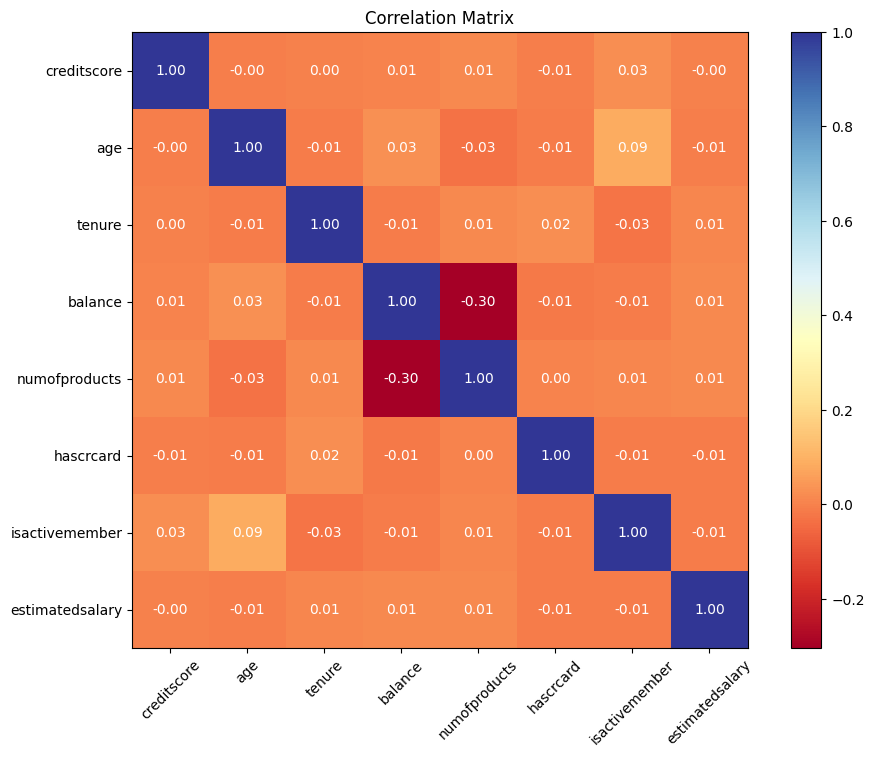

In [27]:
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import numpy as np

# Assuming `indexed_df` is your modified DataFrame
numeric_columns = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
assembled_df = vector_assembler.transform(spark_df)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, 'features').head()[0].toArray()

# Set up the plot
plt.figure(figsize=(11, 8))

# Create a heatmap using matplotlib
heatmap = plt.imshow(correlation_matrix, cmap="RdYlBu", interpolation="nearest")
plt.colorbar(heatmap)

# Annotate the values inside the squares
for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='w')

# Set labels
plt.xticks(np.arange(len(numeric_columns)), numeric_columns, rotation=45)
plt.yticks(np.arange(len(numeric_columns)), numeric_columns)

# Show the plot
plt.title("Correlation Matrix")
plt.show()


In [28]:
# One hot Encoding for categorical attributes (geography and gender)

from pyspark.ml.feature import StringIndexer

# Assuming `spark_df` is your DataFrame
string_indexer_geography = StringIndexer(inputCol="geography", outputCol="geography_index")
string_indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_index")
string_indexer_exited = StringIndexer(inputCol="exited", outputCol="exited_index")

# Fit and transform the DataFrame
indexed_df = string_indexer_geography.fit(spark_df).transform(spark_df)
indexed_df = string_indexer_gender.fit(indexed_df).transform(indexed_df)
indexed_df = string_indexer_exited.fit(indexed_df).transform(indexed_df)

# Drop the original categorical columns
indexed_df = indexed_df.drop("geography", "gender", "exited", "ExitedCategory")

# Display the transformed DataFrame
indexed_df.show()



+-----------+---+------+---------+-------------+---------+--------------+---------------+---------------+------------+------------+
|creditscore|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|geography_index|gender_index|exited_index|
+-----------+---+------+---------+-------------+---------+--------------+---------------+---------------+------------+------------+
|        619| 42|     2|      0.0|            1|        1|             1|      101348.88|            0.0|         1.0|         1.0|
|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|            2.0|         1.0|         0.0|
|        502| 42|     8| 159660.8|            3|        1|             0|      113931.57|            0.0|         1.0|         1.0|
|        699| 39|     1|      0.0|            2|        0|             0|       93826.63|            0.0|         1.0|         0.0|
|        850| 43|     2|125510.82|            1|        1|             1|   

## **Choosing a Machine Learning Algorithm**

Given the critical nature of the problem we are addressing, it is crucial to employ a model that delivers optimal performance. To achieve this, we will explore various machine learning algorithms to discern which one yields the best results. Additionally, we will conduct a comparative analysis of their accuracies. Since our task involves classification, the selected algorithms for consideration are:


K-Nearest Neighbor (KNN)

Logistic Regression (LR)

Gradient Boosting (GB)

RandomForest (RF)

In [29]:
# K - Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming 'indexed_df' is a PySpark DataFrame
features = indexed_df.select([col for col in indexed_df.columns if col != 'exited_index'])
target = indexed_df.select('exited_index')

# Convert PySpark DataFrame to pandas DataFrame
features_pd = features.toPandas()
target_pd = target.toPandas()['exited_index']

# Splitting the dataset into training and test sets
X_train_pd, X_test_pd, y_train, y_test = train_test_split(features_pd, target_pd, test_size=0.25, random_state=42)

# Initialization of the KNN
knn_mod = KNeighborsClassifier(n_neighbors=5)
# Fitting the model with training data
knn_mod.fit(X_train_pd, y_train)

# Compute the model accuracy on the given test data and labels
knn_acc = knn_mod.score(X_test_pd, y_test)
# Return probability estimates for the test data
test_labels = knn_mod.predict_proba(X_test_pd)[:, 1]
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
knn_roc_auc = roc_auc_score(y_test, test_labels)

# Display the results for KNN
print(f'KNN Accuracy: {knn_acc}')
print(f'KNN ROC AUC: {knn_roc_auc}')



KNN Accuracy: 0.768
KNN ROC AUC: 0.5407060435503687


In [30]:
# Logistic Regression Classifier

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'indexed_df' is a PySpark DataFrame
features = indexed_df.select([col for col in indexed_df.columns if col != 'exited_index'])
target = indexed_df.select('exited_index')

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features.columns, outputCol='features')
indexed_df_LRC = assembler.transform(indexed_df)

# Splitting the dataset into training and test sets
(training_data, test_data) = indexed_df_LRC.randomSplit([0.75, 0.25], seed=42)

# Initialize the Logistic Regression model
lr_mod = LogisticRegression(featuresCol='features', labelCol='exited_index', maxIter=100)

# Fit the Logistic Regression model
lr_model = lr_mod.fit(training_data)

# Evaluate the Logistic Regression model on the test set
lr_predictions = lr_model.transform(test_data)
lr_auc = BinaryClassificationEvaluator(labelCol='exited_index').evaluate(lr_predictions, {BinaryClassificationEvaluator.metricName: 'areaUnderROC'})

# Display the results for Logistic Regression
print(f'Logistic Regression Accuracy: {lr_model.summary.accuracy}')
print(f'Logistic Regression AUC: {lr_auc}')



Logistic Regression Accuracy: 0.8056471830056736
Logistic Regression AUC: 0.763358324670061


In [31]:
# Gradient Boosting Classifier

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the Gradient Boosting model
gbt_mod = GBTClassifier(labelCol='exited_index', featuresCol='features', maxIter=10, seed=42)

# Fit the Gradient Boosting model
gbt_model = gbt_mod.fit(training_data)

# Evaluate the Gradient Boosting model on the test set
gbt_predictions = gbt_model.transform(test_data)
gbt_accuracy = gbt_predictions.filter(gbt_predictions['prediction'] == gbt_predictions['exited_index']).count() / gbt_predictions.count()

# Calculate AUC using BinaryClassificationEvaluator
gbt_auc_evaluator = BinaryClassificationEvaluator(labelCol='exited_index', metricName='areaUnderROC')
gbt_auc = gbt_auc_evaluator.evaluate(gbt_predictions)


# Display the results for Gradient Boosting
print(f'Gradient Boosting Accuracy: {gbt_accuracy}')
print(f'Gradient Boosting AUC: {gbt_auc}')


Gradient Boosting Accuracy: 0.8690623709211069
Gradient Boosting AUC: 0.8650621993551


In [32]:
# Random Forest Classifier

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Random Forest Classifier

# Initialize the Random Forest model
rf_mod = RandomForestClassifier(featuresCol='features', labelCol='exited_index', numTrees=10, seed=42)

# Fit the Random Forest model
rf_model = rf_mod.fit(training_data)

# Evaluate the Random Forest model on the test set
rf_predictions = rf_model.transform(test_data)
rf_accuracy = rf_predictions.filter(rf_predictions['prediction'] == rf_predictions['exited_index']).count() / rf_predictions.count()

# Calculate AUC using BinaryClassificationEvaluator
rf_auc_evaluator = BinaryClassificationEvaluator(labelCol='exited_index', metricName='areaUnderROC')
rf_auc = rf_auc_evaluator.evaluate(rf_predictions)

# Display the results for Random Forest
print(f'Random Forest Accuracy: {rf_accuracy}')
print(f'Random Forest AUC: {rf_auc}')

Random Forest Accuracy: 0.8632796365138372
Random Forest AUC: 0.843342532553345


In [33]:
import pandas as pd

# Create a DataFrame with the results
results_data = {
    'Model': ['KNN', 'Logistic Regression', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [knn_acc, lr_model.summary.accuracy, gbt_accuracy, rf_accuracy],
    'ROC AUC': [knn_roc_auc, lr_auc, gbt_auc, rf_auc]
}

results_df = pd.DataFrame(results_data)

# Display the DataFrame
print(results_df)


                 Model  Accuracy  ROC AUC
0                  KNN      0.77     0.54
1  Logistic Regression      0.81     0.76
2    Gradient Boosting      0.87     0.87
3        Random Forest      0.86     0.84


**KNN (K-Nearest Neighbors):**

Accuracy: 76.8%

ROC AUC: 54.1%

The KNN model has relatively low accuracy and ROC AUC compared to other models, indicating that it may not be the best-performing model for this dataset.

**Logistic Regression:**

Accuracy: 80.6%

ROC AUC: 76.3%

The logistic regression model performs better than KNN but may still have room for improvement. The ROC AUC indicates a moderate level of discrimination.

**Gradient Boosting:**

Accuracy: 86.9%

ROC AUC: 86.5%

The gradient boosting model shows higher accuracy and ROC AUC compared to both KNN and logistic regression. It seems to be a strong performer in this context.

**Random Forest:**

Accuracy: 86.3%

ROC AUC: 84.3%

The random forest model also performs well, with accuracy and ROC AUC scores close to those of gradient boosting. It seems to be a robust model for the given task.
In summary, based on the given metrics, the Gradient Boosting and Random Forest models appear to be the most effective for this classification task.

# Optimization



### **Cross Validation and Hyperparameter Tunning**

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.model_selection import GridSearchCV

# Function to perform cross-validation for a given model
def perform_cross_validation(model, param_grid):
    # Initialize CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=BinaryClassificationEvaluator(labelCol='exited_index', metricName='areaUnderROC'),
                              numFolds=5,
                              seed=42)

    # Run cross-validation, and choose the best set of parameters.
    cv_model = crossval.fit(training_data)

    # Get the best model from cross-validation
    best_model = cv_model.bestModel

    # Make predictions on the test set
    predictions = best_model.transform(test_data)

    # Calculate accuracy and AUC
    accuracy = predictions.filter(predictions['prediction'] == predictions['exited_index']).count() / predictions.count()
    auc = BinaryClassificationEvaluator(labelCol='exited_index').evaluate(predictions, {BinaryClassificationEvaluator.metricName: 'areaUnderROC'})

    return best_model, accuracy, auc

# K-Nearest Neighbors with Cross-Validation
knn_mod = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 7]}
knn_cv = GridSearchCV(knn_mod, knn_param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train_pd, y_train)

# Get the best model from cross-validation
best_knn_model = knn_cv.best_estimator_

# Make predictions on the test set
knn_acc_cv = best_knn_model.score(X_test_pd, y_test)
knn_roc_auc_cv = roc_auc_score(y_test, best_knn_model.predict_proba(X_test_pd)[:, 1])

print(f'KNN Accuracy with Cross-Validation: {knn_acc_cv}')
print(f'KNN ROC AUC with Cross-Validation: {knn_roc_auc_cv}')

# Logistic Regression with Cross-Validation
lr_param_grid = ParamGridBuilder().addGrid(lr_mod.regParam, [0.01, 0.1, 1.0]).addGrid(lr_mod.elasticNetParam, [0.0, 0.5, 1.0]).build()  # Example parameter grid
best_lr_model, lr_acc_cv, lr_auc_cv = perform_cross_validation(lr_mod, lr_param_grid)
print(f'Logistic Regression Accuracy with Cross-Validation: {lr_acc_cv}')
print(f'Logistic Regression AUC with Cross-Validation: {lr_auc_cv}')

# Gradient Boosting with Cross-Validation
gbt_param_grid = ParamGridBuilder().addGrid(gbt_mod.maxDepth, [3, 5, 7]).addGrid(gbt_mod.maxIter, [10, 20, 30]).build()  # Example parameter grid
best_gbt_model, gbt_acc_cv, gbt_auc_cv = perform_cross_validation(gbt_mod, gbt_param_grid)
print(f'Gradient Boosting Accuracy with Cross-Validation: {gbt_acc_cv}')
print(f'Gradient Boosting AUC with Cross-Validation: {gbt_auc_cv}')

# Random Forest with Cross-Validation
rf_param_grid = ParamGridBuilder().addGrid(rf_mod.numTrees, [10, 20, 30]).addGrid(rf_mod.maxDepth, [3, 5, 7]).build()  # Example parameter grid
best_rf_model, rf_acc_cv, rf_auc_cv = perform_cross_validation(rf_mod, rf_param_grid)
print(f'Random Forest Accuracy with Cross-Validation: {rf_acc_cv}')
print(f'Random Forest AUC with Cross-Validation: {rf_auc_cv}')


KNN Accuracy with Cross-Validation: 0.768
KNN ROC AUC with Cross-Validation: 0.5407060435503687
Logistic Regression Accuracy with Cross-Validation: 0.8083436596447748
Logistic Regression AUC with Cross-Validation: 0.7665145454865837
Gradient Boosting Accuracy with Cross-Validation: 0.8703015282940934
Gradient Boosting AUC with Cross-Validation: 0.8633409247088251
Random Forest Accuracy with Cross-Validation: 0.86575795125981
Random Forest AUC with Cross-Validation: 0.8596307684175296


In [35]:
# Create a DataFrame with the results of cross validation
results_data = {
    'Model': ['KNN', 'Logistic Regression', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [knn_acc_cv, lr_acc_cv, gbt_acc_cv, rf_acc_cv],
    'ROC AUC': [knn_roc_auc_cv, lr_auc_cv, gbt_auc_cv, rf_auc_cv]
}

results_df = pd.DataFrame(results_data)

# Display the DataFrame
print(results_df)

                 Model  Accuracy  ROC AUC
0                  KNN      0.77     0.54
1  Logistic Regression      0.81     0.77
2    Gradient Boosting      0.87     0.86
3        Random Forest      0.87     0.86


### **Cross Validation and Hyperparameter Tunning**

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# K-Nearest Neighbors with Hyperparameter Tuning
knn_mod = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 7]}
knn_cv = GridSearchCV(knn_mod, knn_param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train_pd, y_train)

# Get the best model from hyperparameter tuning
best_knn_model = knn_cv.best_estimator_

# Make predictions on the test set
knn_acc_cv = best_knn_model.score(X_test_pd, y_test)
knn_roc_auc_cv = roc_auc_score(y_test, best_knn_model.predict_proba(X_test_pd)[:, 1])

print(f'KNN Accuracy with Hyperparameter Tuning: {knn_acc_cv}')
print(f'KNN ROC AUC with Hyperparameter Tuning: {knn_roc_auc_cv}')

# Logistic Regression with Hyperparameter Tuning
lr_mod = LogisticRegression()
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
lr_cv = GridSearchCV(lr_mod, lr_param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train_pd, y_train)

# Get the best model from hyperparameter tuning
best_lr_model = lr_cv.best_estimator_

# Make predictions on the test set
lr_acc_cv = best_lr_model.score(X_test_pd, y_test)
lr_roc_auc_cv = roc_auc_score(y_test, best_lr_model.predict_proba(X_test_pd)[:, 1])

print(f'Logistic Regression Accuracy with Hyperparameter Tuning: {lr_acc_cv}')
print(f'Logistic Regression ROC AUC with Hyperparameter Tuning: {lr_roc_auc_cv}')

# Gradient Boosting with Hyperparameter Tuning
gbt_mod = GradientBoostingClassifier()
gbt_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
gbt_cv = GridSearchCV(gbt_mod, gbt_param_grid, cv=5, scoring='roc_auc')
gbt_cv.fit(X_train_pd, y_train)

# Get the best model from hyperparameter tuning
best_gbt_model = gbt_cv.best_estimator_

# Make predictions on the test set
gbt_acc_cv = best_gbt_model.score(X_test_pd, y_test)
gbt_roc_auc_cv = roc_auc_score(y_test, best_gbt_model.predict_proba(X_test_pd)[:, 1])

print(f'Gradient Boosting Accuracy with Hyperparameter Tuning: {gbt_acc_cv}')
print(f'Gradient Boosting ROC AUC with Hyperparameter Tuning: {gbt_roc_auc_cv}')

# Random Forest with Hyperparameter Tuning
rf_mod = RandomForestClassifier()
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
rf_cv = GridSearchCV(rf_mod, rf_param_grid, cv=5, scoring='roc_auc')
rf_cv.fit(X_train_pd, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = rf_cv.best_estimator_

# Make predictions on the test set
rf_acc_cv = best_rf_model.score(X_test_pd, y_test)
rf_roc_auc_cv = roc_auc_score(y_test, best_rf_model.predict_proba(X_test_pd)[:, 1])

print(f'Random Forest Accuracy with Hyperparameter Tuning: {rf_acc_cv}')
print(f'Random Forest ROC AUC with Hyperparameter Tuning: {rf_roc_auc_cv}')


KNN Accuracy with Hyperparameter Tuning: 0.768
KNN ROC AUC with Hyperparameter Tuning: 0.5407060435503687


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Logistic Regression Accuracy with Hyperparameter Tuning: 0.7996
Logistic Regression ROC AUC with Hyperparameter Tuning: 0.6707544317326827
Gradient Boosting Accuracy with Hyperparameter Tuning: 0.868
Gradient Boosting ROC AUC with Hyperparameter Tuning: 0.862973648179642
Random Forest Accuracy with Hyperparameter Tuning: 0.862
Random Forest ROC AUC with Hyperparameter Tuning: 0.8549027565291901


In [37]:
# Create a DataFrame with the results for Hyperparameter Tuning
results_data = {
    'Model': ['KNN', 'Logistic Regression', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [knn_acc_cv, lr_acc_cv, gbt_acc_cv, rf_acc_cv],
    'ROC AUC': [knn_roc_auc_cv, lr_roc_auc_cv, gbt_roc_auc_cv, rf_roc_auc_cv]
}

results_df = pd.DataFrame(results_data)

# Display the DataFrame
print(results_df)

                 Model  Accuracy  ROC AUC
0                  KNN      0.77     0.54
1  Logistic Regression      0.80     0.67
2    Gradient Boosting      0.87     0.86
3        Random Forest      0.86     0.85
